<a href="https://colab.research.google.com/github/Babs-Coding/Refonte/blob/main/Exercise_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

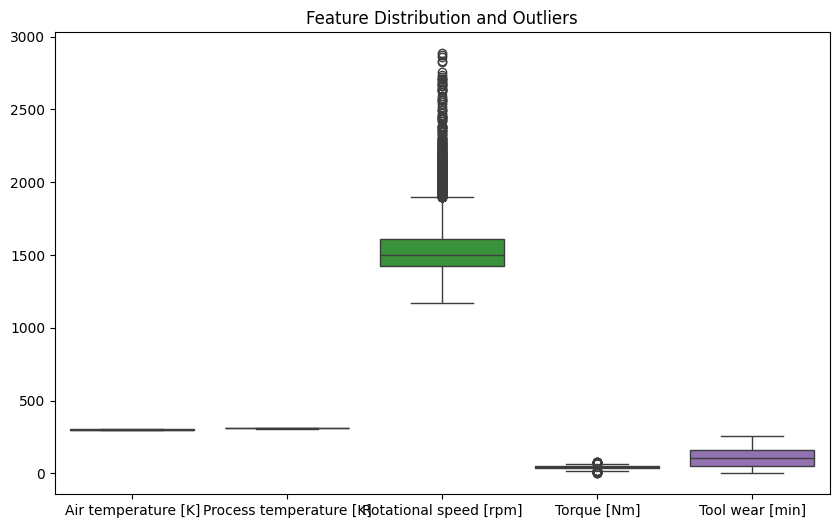

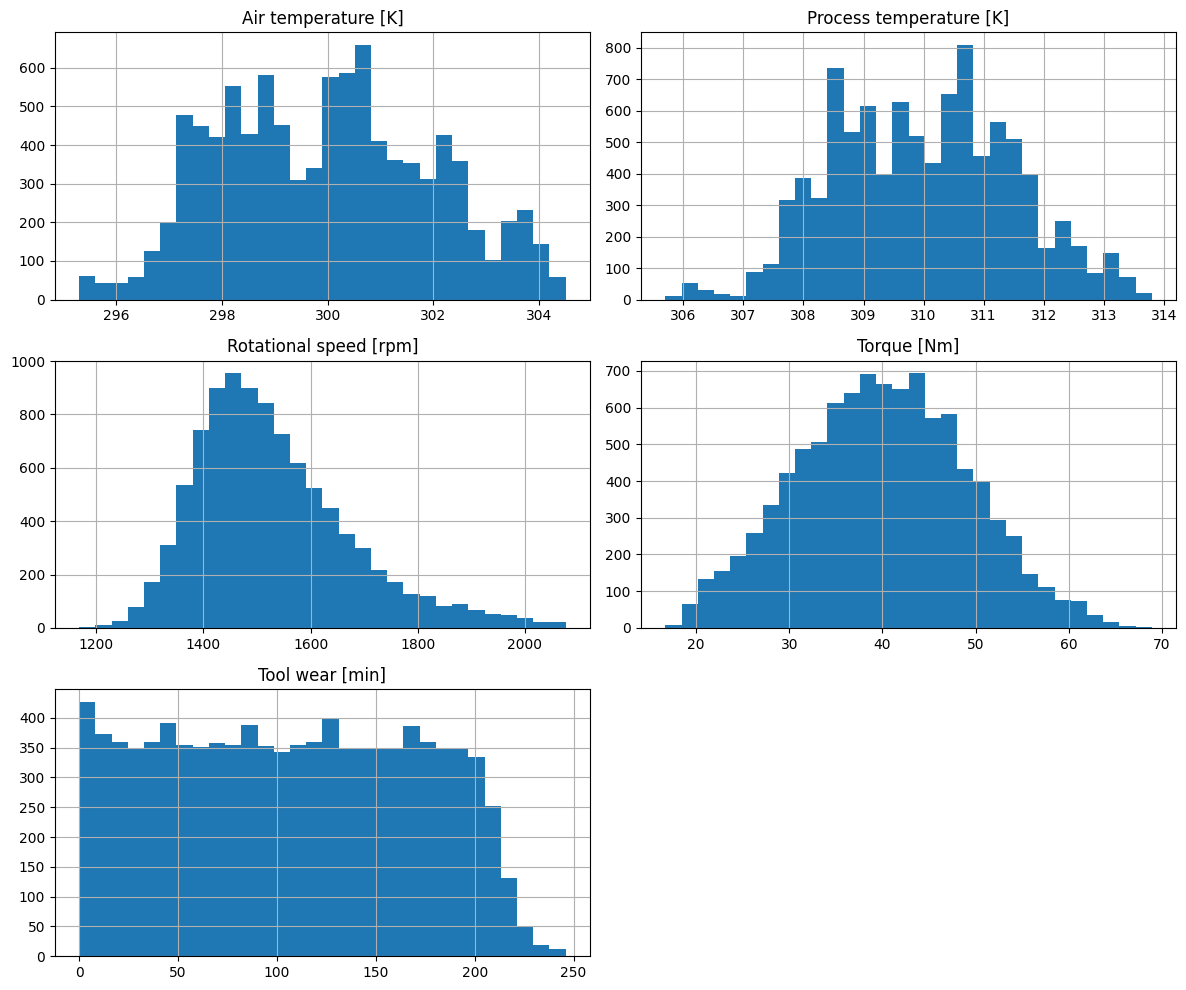

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('machine failure.csv')

label_encoder = LabelEncoder()
df.head()
df.isnull().sum()
df = pd.get_dummies(df, columns=['Product ID', 'Type'], drop_first=True)
df.select_dtypes(include=['object']).columns


plt.figure(figsize=(10, 6))
sns.boxplot(data=df[['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']])
plt.title('Feature Distribution and Outliers')
plt.show()


df = df[(np.abs(stats.zscore(df.select_dtypes(include=['float64', 'int64']))) < 3).all(axis=1)]

#EDA
df[['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']].hist(figsize=(12, 10), bins=30)
plt.tight_layout()
plt.show()

correlation_matrix = df.corr()
#correlation_matrix = df.select_dtypes(include=np.number).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Plot Tool wear vs Machine failure
sns.boxplot(x='Machine failure', y='Tool wear [min]', data=df)
plt.title('Tool Wear vs Machine Failure')
plt.show()

# Plot Torque vs Machine failure
sns.boxplot(x='Machine failure', y='Torque [Nm]', data=df)
plt.title('Torque vs Machine Failure')
plt.show()

# Plot Rotational speed vs Machine failure
sns.boxplot(x='Machine failure', y='Rotational speed [rpm]', data=df)
plt.title('Rotational Speed vs Machine Failure')
plt.show()

# Plot between failure types and Machine failure
sns.heatmap(df[['TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'Machine failure']].corr(), annot=True, cmap='coolwarm')
plt.title('Failure Types Correlation')
plt.show()


df['Tool wear rate'] = df['Tool wear [min]'].diff()
df['Torque rolling_avg'] = df['Torque [Nm]'].rolling(window=5).mean()
df['Rotational speed rolling_avg'] = df['Rotational speed [rpm]'].rolling(window=5).mean()


scaler = StandardScaler()
df[['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']] = scaler.fit_transform(
    df[['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']])

#Model Building

X = df.drop(columns=['Machine failure'])
y = df['Machine failure']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

from sklearn.model_selection import GridSearchCV


param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, None]}
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

# Model Evaluation
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve

# ROC curve
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)' % roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()












In [ ]:
# For the model performances using the 4 metrics shown which are accuracy, Precision, Recall and F1-Score
# Accuracy: having high performance values clearly shown with Random forest,
# precision: This shows just how many predicted failures actually failed
# Recall: this shows just how many actual failures the model was able to catch
#f1-score this is showing a balance of 2 models being precison and recall given the results of both

#AUC close to 1.0 = excellent model.
#The curve shape indicates good classification power, distinguishing between failures and non-failures well.

#Precision-Recall Curve:
#important for imbalanced datasets.
#if recall stays high with decent precision, your model is well-tuned for rare event detection (rare events being failures in this case).